# Car Color Classification

In this notebook, I aim to create a classifier, that classifies images by colors.

Colors used for this task:
- black
- blue
- brown
- gray
- green
- orange
- red
- white
    
### General chain of actions

1) Acquire sufficient amount of data
- for this task I have created a simple webscrapper https://github.com/kubosis/cars_com_scrapper that scrapes cars.com for car and its color
- I have acquired around 900 cars per color
- Note: Some of the images have wrong color (as people who posted them on the site simply mislabeled their insertion or did not pay attention to the exterior color at all. Some cars didn't have any image at all. Therefore, a basic manual dataset cleaning was done)
         
2) Choose a model sufficient for this task
- I am going to leverage pretrained ResNet network for this task, as it demonstrated capabilities of extracting information from images. I will only fine-tune its last layer for this classification task

3) Evaluation of the results
- I will evaluate the trained network on the testing (previously unseen) data. In the following discussion I will analyze accuracies of the network. 
- I will also analyze on which typical examples were the network wrong. My hypothesis now before the testing is that colors like light gray might be easily mislabeled as white even by a human, therefore making it hard for the network to distinguish these two and their alike.



In [1]:
# Imports
from typing import Final
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights

import numpy as np

import matplotlib.pyplot as plt

from PIL import Image

from training import Trainer

### Load the data

In [2]:
DATASET_DIR: Final[str] = '../data/'
colors_count: Final[int] = 8 
batch_size: Final[int] = 32

In [3]:
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transform =  transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet requires this dimension as input
        transforms.ToTensor(),
        transforms.Normalize(*stats), # these numbers were used for highly successful ResNet. I don't really understand the intuition behind them, but they empirically proved to be great for these kinds of tasks
    ])

In [4]:
dataset = datasets.ImageFolder(root=DATASET_DIR, transform=transform)
train_size = int(0.7 * len(dataset))  # 70% training 
test_size = int(0.2 * len(dataset))  # 20% test
val_size = len(dataset) - train_size - test_size # 10% validation

# split to train test validation
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

dataset_dict = {
    'train': train_dataset,
    'test': test_dataset,
    'val': val_dataset
}
print(f"size of training dataset: {len(train_dataset)}\nsize of validation dataset: {len(val_dataset)}\nsize of test dataset: {len(test_dataset)}")

size of training dataset: 5079
size of validation dataset: 726
size of test dataset: 1451


### Let's Visualize the dataset

From the visualization, we can see, that our dataset is balanced

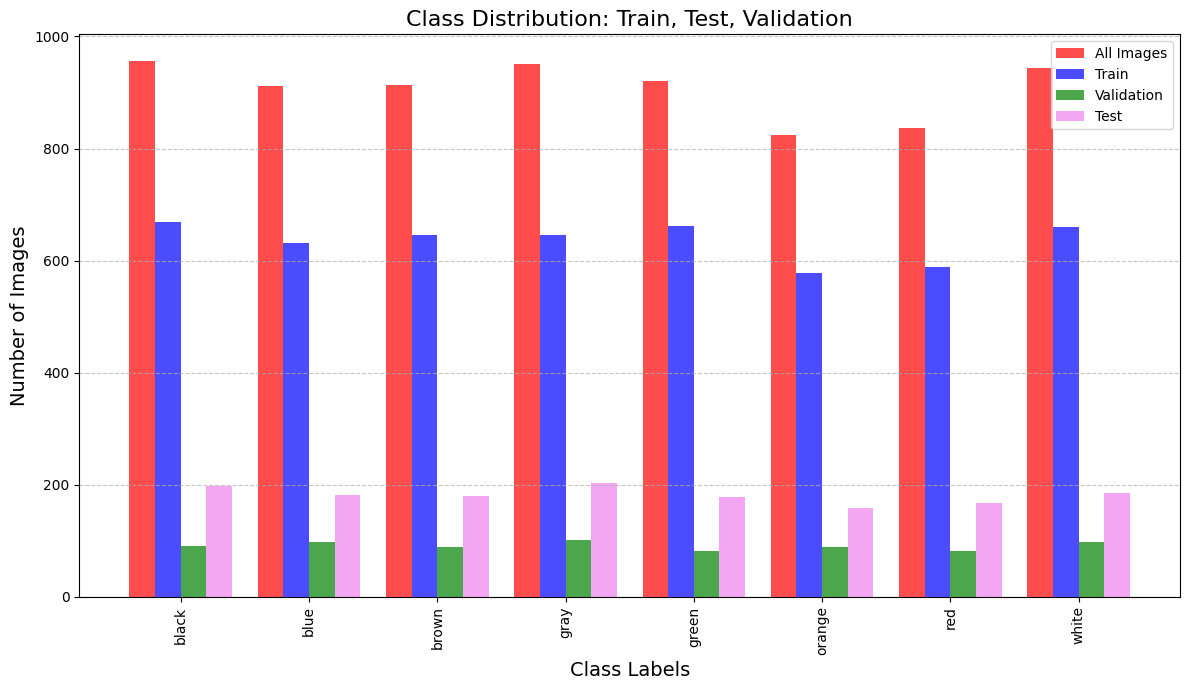

In [5]:
full_targets = dataset.targets

train_targets = [full_targets[i] for i in train_dataset.indices]
test_targets = [full_targets[i] for i in test_dataset.indices]
val_targets = [full_targets[i] for i in val_dataset.indices]

train_counts = Counter(train_targets)
test_counts = Counter(test_targets)
val_counts = Counter(val_targets)

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
classes = [idx_to_class[idx] for idx in sorted(train_counts.keys())]

class_counts = list(Counter(dataset.targets).values())

train_sizes = [train_counts[idx] for idx in sorted(train_counts.keys())]
val_sizes = [val_counts[idx] for idx in sorted(val_counts.keys())]
test_sizes = [test_counts[idx] for idx in sorted(test_counts.keys())]


x = range(len(classes))  

plt.figure(figsize=(12, 7))
plt.bar(x, class_counts, width=0.2, label='All Images', color='red', align='center', alpha=0.7)
plt.bar([i + 0.2 for i in x], train_sizes, width=0.2, label='Train', color='blue', align='center', alpha=0.7)
plt.bar([i + 0.4 for i in x], val_sizes, width=0.2, label='Validation', color='green', align='center', alpha=0.7)
plt.bar([i + 0.6 for i in x], test_sizes, width=0.2, label='Test', color='violet', align='center', alpha=0.7)

plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Class Distribution: Train, Test, Validation', fontsize=16)
plt.xticks([i + 0.3 for i in x], classes, rotation=90, ha='center')  
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  
plt.show()

### Design the model

I will use pretrained ResNet from torchvision.models for this task. The only thing I will do is replace models final linear layer with new one and train it on the training data.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)  # Load pretrained ResNet18

resnet.fc = nn.Linear(resnet.fc.in_features, colors_count)
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss() # typical loss function for multi class classification
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

trainer = Trainer(dataset_dict, batch_size, verbose=True, patience=5)

In [7]:
resnet = trainer.train(resnet, criterion, optimizer, device, num_epochs=100) # there won't be 100 epochs almost for sure thanks to early stopping
torch.save(resnet.state_dict(), 'saved_models/resnet_car_color_classifier.pth')

[INFO] training on cuda for 100 epochs
[INFO] Epoch 1/100


[TRAIN] Epoch 1: 100%|██████████| 159/159 [00:48<00:00,  3.28it/s]


[TRAIN] Loss: 1.0145 Acc: 0.6415


[VAL] Epoch 1: 100%|██████████| 23/23 [00:06<00:00,  3.78it/s]


[VAL] Loss: 0.9976 Acc: 0.6212, best loss: 0.9976 in epoch: 0
[INFO] Epoch 2/100


[TRAIN] Epoch 2: 100%|██████████| 159/159 [00:47<00:00,  3.38it/s]


[TRAIN] Loss: 0.7538 Acc: 0.7438


[VAL] Epoch 2: 100%|██████████| 23/23 [00:05<00:00,  3.84it/s]


[VAL] Loss: 1.0283 Acc: 0.6653, best loss: 0.9976 in epoch: 0
[INFO] Epoch 3/100


[TRAIN] Epoch 3: 100%|██████████| 159/159 [00:46<00:00,  3.39it/s]


[TRAIN] Loss: 0.6249 Acc: 0.7917


[VAL] Epoch 3: 100%|██████████| 23/23 [00:05<00:00,  3.86it/s]


[VAL] Loss: 0.9053 Acc: 0.6846, best loss: 0.9053 in epoch: 2
[INFO] Epoch 4/100


[TRAIN] Epoch 4: 100%|██████████| 159/159 [00:46<00:00,  3.39it/s]


[TRAIN] Loss: 0.5143 Acc: 0.8242


[VAL] Epoch 4: 100%|██████████| 23/23 [00:05<00:00,  3.86it/s]


[VAL] Loss: 0.7699 Acc: 0.7617, best loss: 0.7699 in epoch: 3
[INFO] Epoch 5/100


[TRAIN] Epoch 5: 100%|██████████| 159/159 [00:47<00:00,  3.34it/s]


[TRAIN] Loss: 0.3953 Acc: 0.8716


[VAL] Epoch 5: 100%|██████████| 23/23 [00:05<00:00,  3.91it/s]


[VAL] Loss: 0.7231 Acc: 0.7548, best loss: 0.7231 in epoch: 4
[INFO] Epoch 6/100


[TRAIN] Epoch 6: 100%|██████████| 159/159 [00:47<00:00,  3.38it/s]


[TRAIN] Loss: 0.3031 Acc: 0.8988


[VAL] Epoch 6: 100%|██████████| 23/23 [00:05<00:00,  3.95it/s]


[VAL] Loss: 1.1075 Acc: 0.6612, best loss: 0.7231 in epoch: 4
[INFO] Epoch 7/100


[TRAIN] Epoch 7: 100%|██████████| 159/159 [00:46<00:00,  3.39it/s]


[TRAIN] Loss: 0.2331 Acc: 0.9218


[VAL] Epoch 7: 100%|██████████| 23/23 [00:05<00:00,  3.86it/s]


[VAL] Loss: 1.4608 Acc: 0.6625, best loss: 0.7231 in epoch: 4
[INFO] Epoch 8/100


[TRAIN] Epoch 8: 100%|██████████| 159/159 [00:47<00:00,  3.38it/s]


[TRAIN] Loss: 0.2135 Acc: 0.9275


[VAL] Epoch 8: 100%|██████████| 23/23 [00:06<00:00,  3.83it/s]


[VAL] Loss: 1.0314 Acc: 0.7355, best loss: 0.7231 in epoch: 4
[INFO] Epoch 9/100


[TRAIN] Epoch 9: 100%|██████████| 159/159 [00:47<00:00,  3.38it/s]


[TRAIN] Loss: 0.1489 Acc: 0.9529


[VAL] Epoch 9: 100%|██████████| 23/23 [00:05<00:00,  3.84it/s]


[VAL] Loss: 1.2019 Acc: 0.7218, best loss: 0.7231 in epoch: 4
[INFO] Epoch 10/100


[TRAIN] Epoch 10: 100%|██████████| 159/159 [00:46<00:00,  3.41it/s]


[TRAIN] Loss: 0.1534 Acc: 0.9506


[VAL] Epoch 10: 100%|██████████| 23/23 [00:05<00:00,  3.86it/s]

[VAL] Loss: 1.1897 Acc: 0.7342, best loss: 0.7231 in epoch: 4
[INFO] Early stopping triggered at epoch 10, loading model from epoch 5
[SUCCESS] model trained successfully


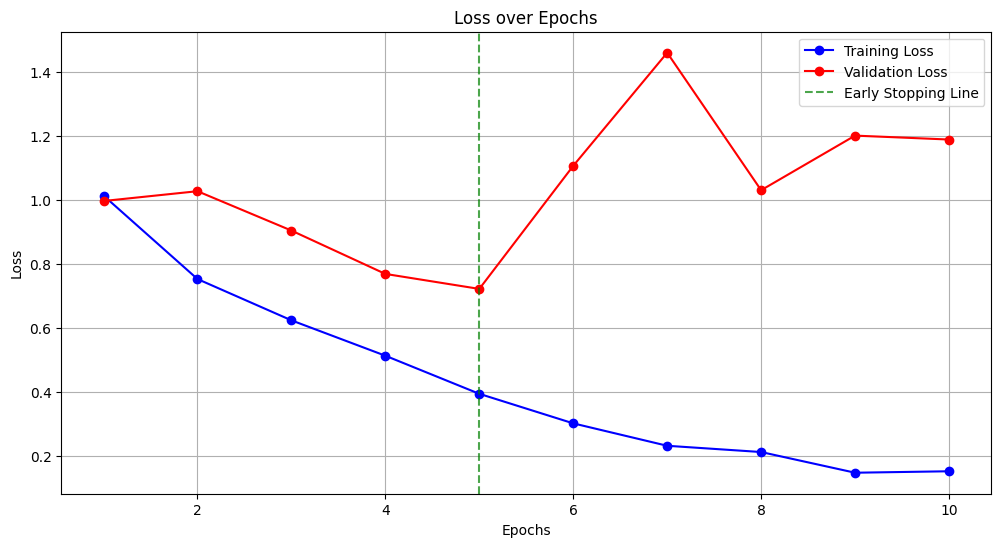

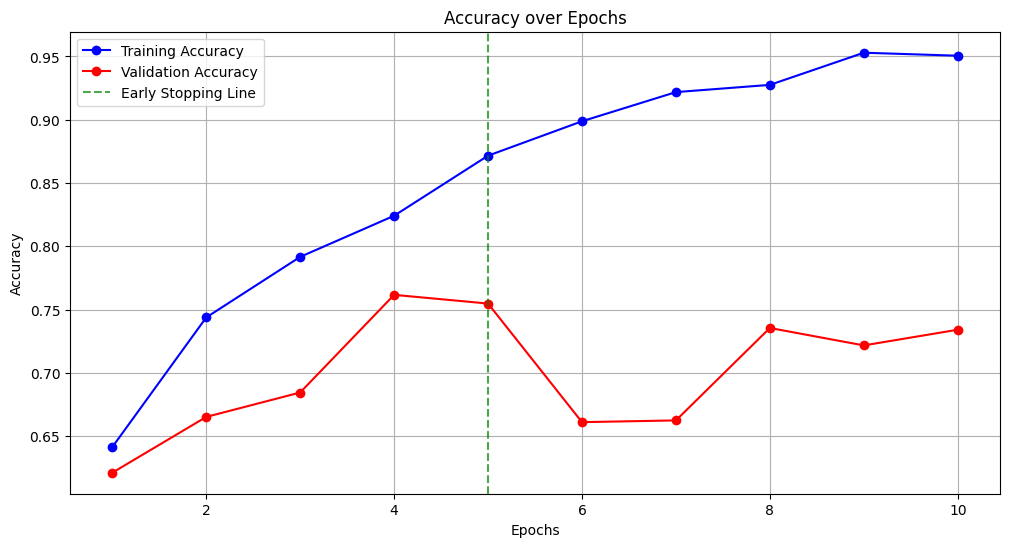

In [8]:
### Let's visualize the training metrics

trn_loss_epochs = trainer.trn_loss_epochs
val_loss_epochs = trainer.val_loss_epochs

trn_acc_epochs = [x.cpu().numpy() for x in trainer.trn_acc_epochs]
val_acc_epochs = [x.cpu().numpy() for x in trainer.val_acc_epochs]

early_stopping_loss = np.argmin(val_loss_epochs) + 1

epochs = range(1, len(trn_loss_epochs) + 1)

# Training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, trn_loss_epochs, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_epochs, 'ro-', label='Validation Loss')
plt.axvline(early_stopping_loss, color='g', linestyle='--', label='Early Stopping Line', alpha=0.7)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, trn_acc_epochs, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_epochs, 'ro-', label='Validation Accuracy')
plt.axvline(early_stopping_loss, color='g', linestyle='--', label='Early Stopping Line', alpha=0.7)

plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()


### Comments:

From the results, we can see, that the best validation accuracy was just above 75% and was achieved in the 5th epoch. Early stopping mechanism waited for (patience=5) epochs, during these epochs the training accuracy was growing higher (except for the last epoch, probably due to a proximity to local minima at that point), but the validation loss was never lower that in the epoch 5. (The model was becoming overfitted)

In [9]:
trainer.test(resnet, device)

[INFO] testing on cuda


[TEST] : 100%|██████████| 46/46 [00:13<00:00,  3.39it/s]

[SUCCESS] Testing ended with accuracy 75.19%


In [10]:
test_acc = float(trainer.test_acc.cpu())
test_labels = list(map(int, trainer.test_labels))
test_correct_labels = list(map(bool, trainer.test_correct_labels)) 

len(test_labels)

1451

### Discussion

The model was able to acquire testing accuracy of 75.19% on the unseen data. This is not that great. We will analyze the mislabeled images below:

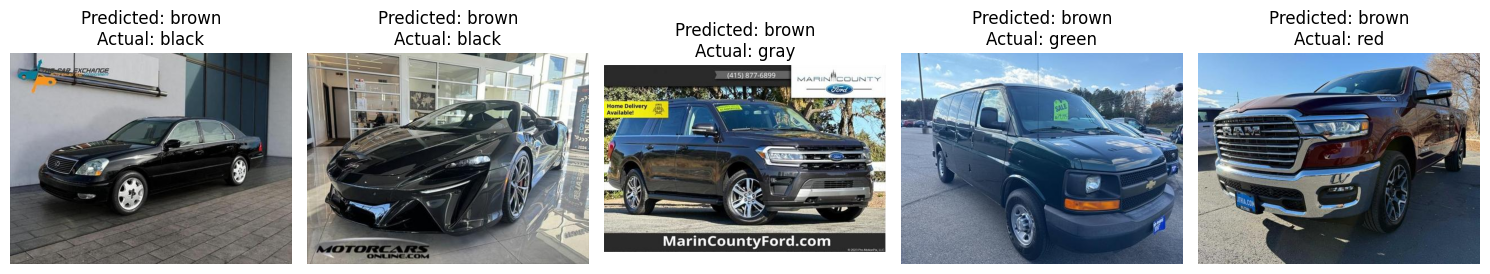

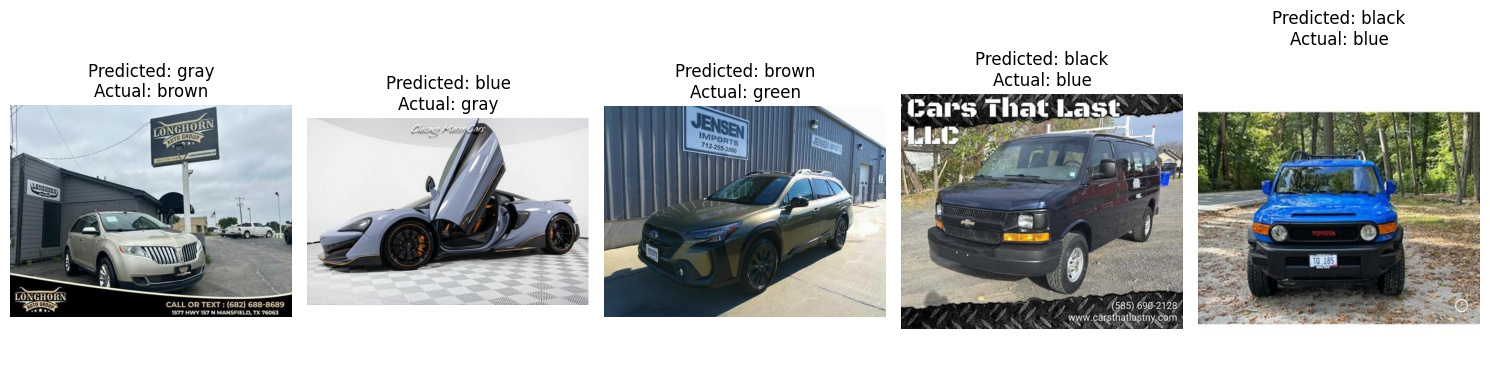

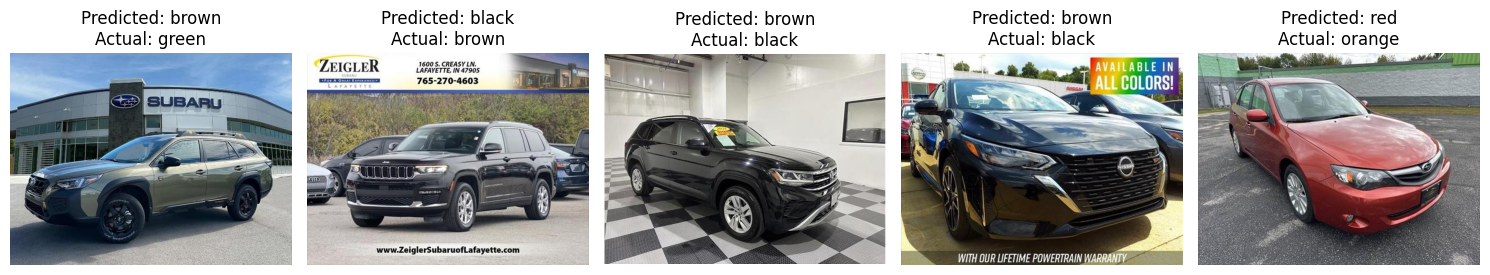

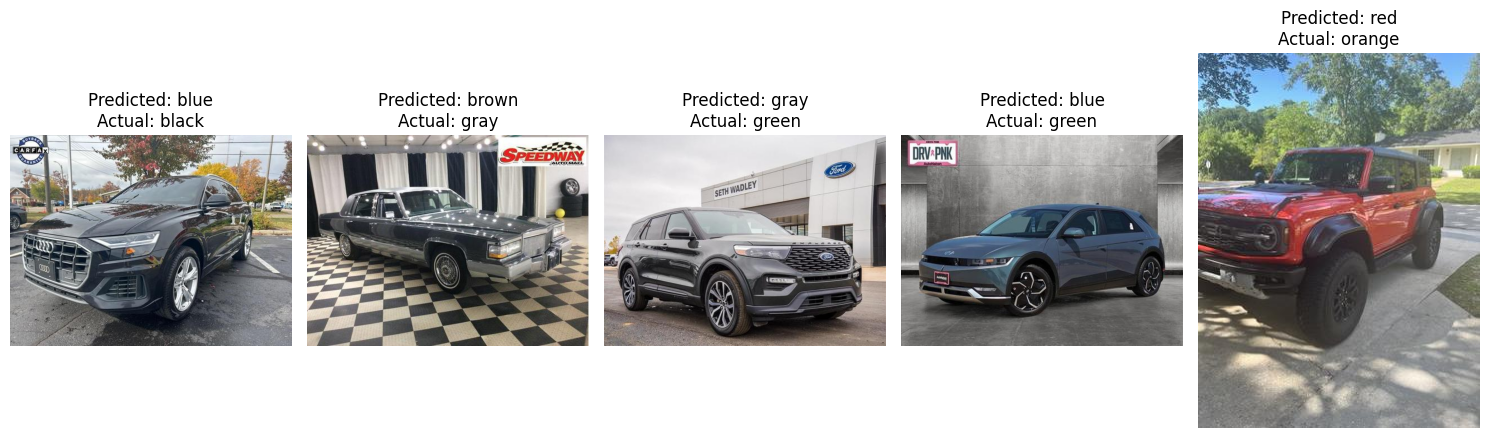

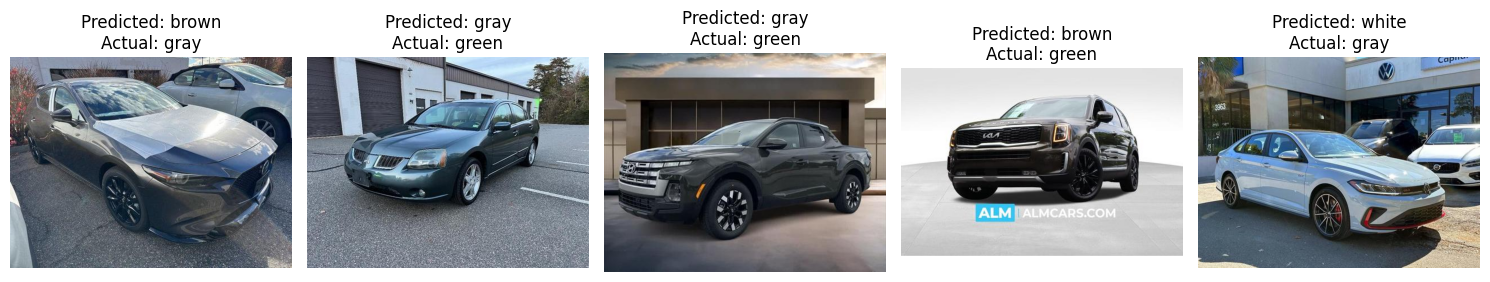

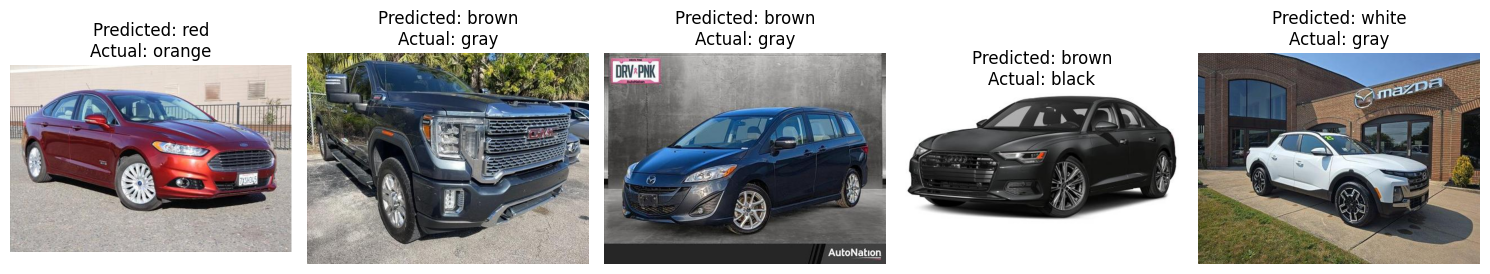

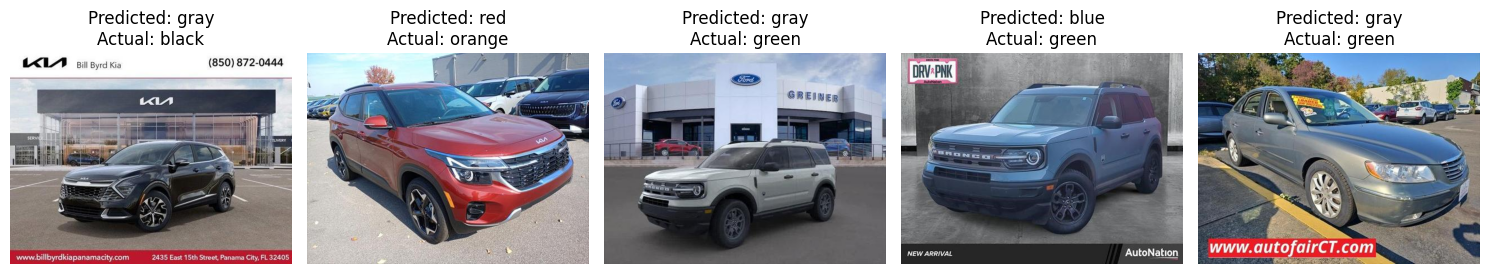

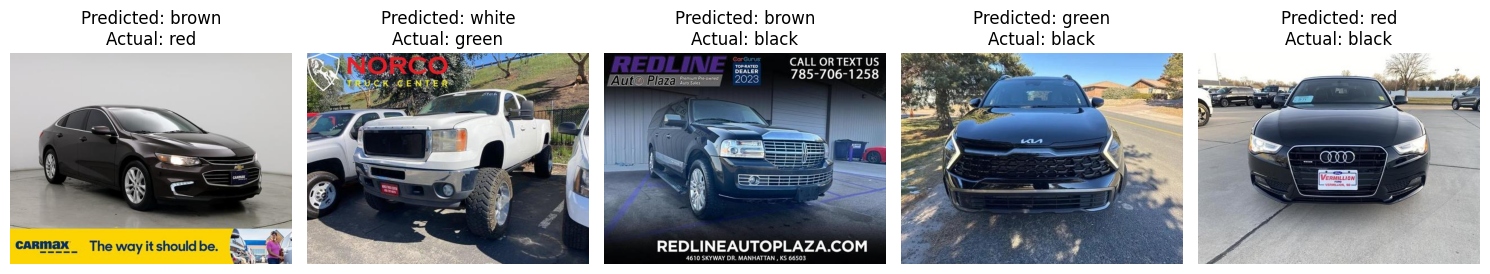

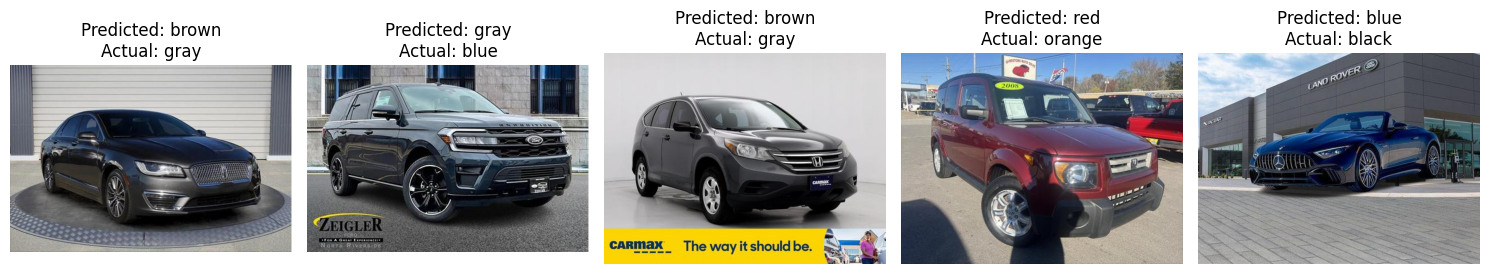

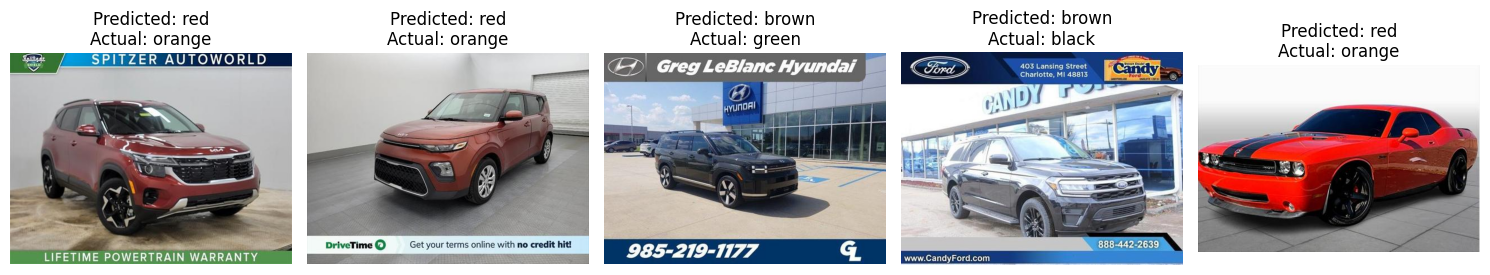

In [13]:
def visualize_mislabeled_images(image_paths, labels, test_labels, test_correct_labels, label_map, num_images=5, num_rows=10):
    # Get indices of mislabeled images
    mislabeled_indices = [i for i, correct in enumerate(test_correct_labels) if not correct]

    if not mislabeled_indices:
        print("No mislabeled images to display.")
        return

    # Select a subset of mislabeled indices
    selected_indices = np.random.choice(mislabeled_indices, num_images * num_rows, replace=False)
    for i in range(num_rows):
     
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        
        row_indexes = selected_indices[i * num_images: (i + 1) * num_images]
        for idx, ax in zip(row_indexes, axes):
            image_path = image_paths[idx]
            true_label = labels[idx]
            predicted_label = test_labels[idx]
    
            image = Image.open(image_path).convert("RGB")
    
            ax.imshow(image)
            ax.set_title(f"Predicted: {label_map[predicted_label]}\nActual: {label_map[true_label]}")
            ax.axis('off')
    
        plt.tight_layout()
        plt.show()
    
test_loader = trainer.data_loaders['test']
test_dataset_indices = test_loader.dataset.indices
all_samples = test_loader.dataset.dataset.samples
test_samples = [all_samples[i] for i in test_dataset_indices]
label_map = test_loader.dataset.dataset.classes

img_paths, true_labels = zip(*test_samples)
img_paths = list(img_paths)
true_labels = list(true_labels)

visualize_mislabeled_images(img_paths, true_labels, test_labels, test_correct_labels, label_map)


### Comments:

From the mislabeled data, we can see that the model is better that it first seemed. Some of the data points are simply a noise that was not deleted during the preprocessing (e.g. 4th row from the bottom, middle car). For most of the other cars in the mislabeled images, I suppose even humans would have a hard time classifying their color correctly (e.g. the very last car), this correlates with my hypothesis from the point 3. in the General Chain of Actions section. 

Some of the cars have completely wrong label. But from the drafted images, we can assume, that they are only a minor part of the dataset. 

Given these new facts I assume the model can label unlabeled car data with their color correctly in the most cases. At least so that it correlates with what a human may think.

### Possible improvements

In order for the model to give us better results, the dataset should not contain any noise, therefore more excessive cleaning should be performed before the training. 

Also we could use less color classes, e.g red and orange may be seen as one label, as these color labels are sometimes misclassified even by poeple, who upload the images to the cars.com 



-------------------------------

Author: Jakub Sukdol

email: kubasukdol@gmail.com